<a href="https://colab.research.google.com/github/Ritikj55/Saliency-Maps-of-Cracked-Concrete/blob/main/Crack_segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
%tensorflow_version 2.x
import tensorflow as tf
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
cwd = os.getcwd()
from PIL import Image
import time
import copy
import random
import re
import shutil
import matplotlib.image as mpimg
%matplotlib inline


In [2]:
import tensorflow_hub as hub

In [3]:
!wget   https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip

--2021-04-04 03:10:43--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/5y9wdsg2zt-2.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.101.136
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.101.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 240847944 (230M) [application/octet-stream]
Saving to: ‘5y9wdsg2zt-2.zip’

5y9wdsg2zt-2.zip    100%[===================>] 229.69M  43.4MB/s    in 5.2s    

2021-04-04 03:10:49 (44.2 MB/s) - ‘5y9wdsg2zt-2.zip’ saved [240847944/240847944]



In [4]:
!unzip 5y9wdsg2zt-2

Archive:  5y9wdsg2zt-2.zip
  inflating: Concrete Crack Images for Classification.rar  


In [ ]:
! unrar x Concrete_Crack_Images_for_Classification

In [9]:
if  os.path.exists('/content/Positive'):
  crack_images_positive = os.listdir('/content/Positive')
  print("Number of Crack Images: ", len(crack_images_positive))

Number of Crack Images:  20000


In [10]:
if  os.path.exists('/content/Negative'):
  crack_images_negative = os.listdir('/content/Negative')
  print("Number of Crack Images: ",len(crack_images_negative))

Number of Crack Images:  20000


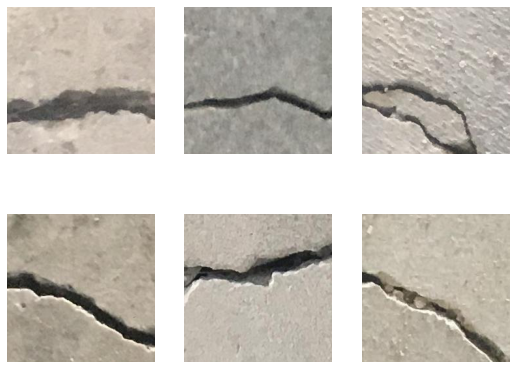

In [11]:
if  os.path.exists('/content/Positive'):
 random_indeces = np.random.randint(0,len(crack_images_positive),size=6)
 random_array = np.array(crack_images_positive)[random_indeces.astype(int)]
 f,axx = plt.subplots(2,3,figsize=(9,7))
 #plt.axis('off')
 c=0
 for i in range (2):
    for j in range(3):
        axx[i,j].imshow(mpimg.imread(os.path.join('/content/Positive',random_array[c])))
        axx[i,j].axis('off')
        c=c+1

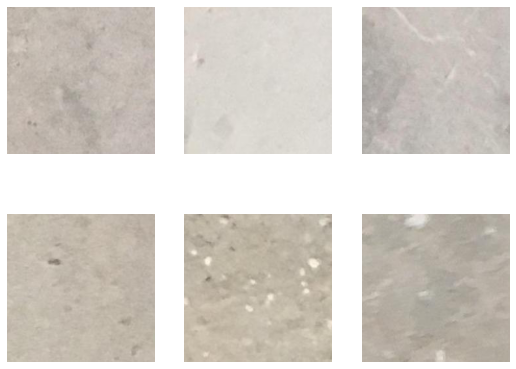

In [12]:
if  os.path.exists('/content/Negative'):
 random_indeces = np.random.randint(0,len(crack_images_positive),size=6)
 random_array = np.array(crack_images_negative)[random_indeces.astype(int)]
 f,axx = plt.subplots(2,3,figsize=(9,7))
 #plt.axis('off')
 c=0
 for i in range (2):
    for j in range(3):
        axx[i,j].imshow(mpimg.imread(os.path.join('/content/Negative',random_array[c])))
        axx[i,j].axis('off')
        c=c+1

In [13]:
files = os.listdir('/content')
def create_training_data(folder_name):
  train_dir = f"/content/train/{folder_name}"
  for f in files :
    search_file = re.search(folder_name,f)
    if search_file :
      shutil.move(f'/content/{folder_name}',train_dir)


In [14]:
if not os.path.exists('/content/train/Positive'):
  create_training_data('Positive')
  create_training_data('Negative')

In [15]:
k = os.listdir('/content/train/Positive')
len(k)

20000

In [16]:
if not os.path.exists('/content/val/Positive'):
   os.makedirs('/content/val/Positive')
   os.makedirs('/content/val/Negative')

In [17]:
k=os.listdir('/content/val/Positive')
l1=len(k)

In [18]:
base_dir = '/content'
positive_train = base_dir + "/train/Positive"
negative_train  =  base_dir + "/train/Negative"
positive_val =   base_dir + "/val/Positive"
negative_val =  base_dir + "/val/Negative"
positive_file = os.listdir(positive_train)
negative_file = os.listdir(negative_train)



In [19]:
if l1 == 0 :
  for f  in positive_file :
    if random.random() > 0.85 :
      shutil.move(f'{positive_train}/{f}',positive_val)

In [20]:
l2 = len(os.listdir('/content/val/Negative'))
if l2 == 0 :
  for f in negative_file:
    if random.random() > 0.85 :
      shutil.move(f'{negative_train}/{f}',negative_val)

In [21]:
def Convert_img(image):
  
  img=cv2.imread(image)
   
  #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if image is not None :
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(227,227))/255.0
    
    return img
  else :
    return None   
  # format it to be in the RGB colorspace
   

  #  resize to 300x300 and normalize pixel values to be in the range [0, 1]
  #img = cv2.resize(img, (300, 300)) / 255.0

In [22]:
trainX ,trainY ,valX,valY= [] , [] ,[] ,[]
train_positive  = os.listdir(positive_train)
train_negative = os.listdir(negative_train)
val_positive = os.listdir(positive_val)
val_negative = os.listdir(negative_val)

In [ ]:
for f in train_positive[0:int(len(train_positive)/4)]:
  #print(f)
  k= base_dir +'/train/Positive/'+f
  print(k)
  trainX.append(Convert_img(k))
  trainY.append(1)
  #print(f)

In [88]:
for f in train_negative[0:int(len(train_negative)/4)]:
 k= base_dir +'/train/Negative/'+f
 trainX.append(Convert_img(base_dir + '/train/Negative/'+f))
 trainY.append(0)

In [90]:
#trainX.clear()

8500

In [ ]:
for f in val_positive:
  k= base_dir +'/val/Positive/'+f
  valX.append(Convert_img(base_dir + '/val/Positive/'+f))
  valY.append(1)

In [24]:
for f in val_negative:
  k= base_dir +'/val/Negative/'+f
  img =Convert_img(k)
  if img is not None :
    valX.append(img)
    valY.append(0)

In [25]:
inputs = tf.keras.layers.Input(shape =(227,227,3))
resnet = tf.keras.applications.ResNet50(input_shape=(227, 227, 3),
    include_top=False, weights='imagenet' )
for layers in resnet.layers :
  layers.trainable = False
model = tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu',padding='same')(resnet.output)
model  = tf.keras.layers.GlobalAveragePooling2D()(model)
model =  tf.keras.layers.Dense(2,activation='softmax')(model)
model =  tf.keras.Model(inputs= resnet.inputs,outputs = model )

94773248/94765736 [==============================] - 2s 0us/step


In [26]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 227, 227, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 233, 233, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 114, 114, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 114, 114, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

# Do Salience

In [102]:
def do_salience(img ,model,label):
  img = np.expand_dims(img,axis=0)
  num_classes = 2
  expected_output=tf.one_hot([label]*img.shape[0],num_classes)
  with tf.GradientTape() as tape :
    input = tf.cast(img,tf.float32)
    tape.watch(input)
    predictions = model(input)
    loss = tf.keras.losses.categorical_crossentropy(
                 expected_output,predictions        
    )  
    print(predictions)
  gradients = tape.gradient(loss,input)
  grayscale_tensor = tf.reduce_sum(tf.abs(gradients),axis=-1)
  normalised_tensor = tf.cast(
        255.0 * (grayscale_tensor-tf.reduce_min(grayscale_tensor))/
        (tf.reduce_max(grayscale_tensor)-tf.reduce_min(grayscale_tensor)),
        tf.uint8,
  )
  normalised_tensor= tf.squeeze(normalised_tensor)
 # print(normalised_tensor.shape)
  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(normalised_tensor, cmap='gray')
  plt.show()
  #salient_image_name = prefix + image
  #normalized_tensor = tf.expand_dims(normalized_tensor, -1)
  #normalized_tensor = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
  #writer = tf.io.write_file(salient_image_name, normalized_tensor)
  gradient_color = cv2.applyColorMap(normalised_tensor.numpy(), cv2.COLORMAP_HOT)
  gradient_color = gradient_color / 255.0
  #print("shape of grd ", {gradient_color.shape})
  k = np.expand_dims(gradient_color,axis=0)
  super_imposed = cv2.addWeighted(img, 0.5, k, 0.5, 0.0)
  j = tf.squeeze(super_imposed)
  plt.figure(figsize=(8, 8))
  plt.imshow(j)
  plt.axis('off')
  plt.show()





In [ ]:
#train_batches = trainX.batch(32)
!wget --no-check-certificate 'https://pjreddie.com/media/files/resnet50.weights' -O 0_epochs.h5

--2021-04-03 16:39:03--  https://pjreddie.com/media/files/resnet50.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91303604 (87M) [application/octet-stream]
Saving to: ‘0_epochs.h5’

0_epochs.h5         100%[===================>]  87.07M   100MB/s    in 0.9s    

2021-04-03 16:39:03 (100 MB/s) - ‘0_epochs.h5’ saved [91303604/91303604]



In [28]:
img =!wget 'https://www.google.com/imgres?imgurl=https%3A%2F%2Fwww.devooghthouselifters.com%2Fwp-content%2Fuploads%2F2019%2F11%2Fcrack-floor-scaled.jpeg&imgrefurl=https%3A%2F%2Fwww.devooghthouselifters.com%2Fhow-to-repair-cracks-in-poured-concrete-slabs%2F&tbnid=ElFrfEtT2mTpGM&vet=12ahUKEwjLiNLVz-PvAhVEzzgGHYSVDlgQMygHegUIARDYAQ..i&docid=VxYRdvqDoWYchM&w=2560&h=1920&q=cracked%20concrete%20image&ved=2ahUKEwjLiNLVz-PvAhVEzzgGHYSVDlgQMygHegUIARDYAQ'

In [78]:
img ='/content/train/Positive/00002.jpg'  
#img = '/content/imgres?imgurl=https:%2F%2Fwww.devooghthouselifters.com%2Fwp-content%2Fuploads%2F2019%2F11%2Fcrack-floor-scaled.jpeg&imgrefurl=https:%2F%2Fwww.devooghthouselifters.com%2Fhow-to-repair-cracks-in-poured-concrete-slabs%2F&tbnid=ElFrfEtT2mTp'
img=  Convert_img(img)
img.shape
label =1

tf.Tensor([[0.35271803 0.64728194]], shape=(1, 2), dtype=float32)


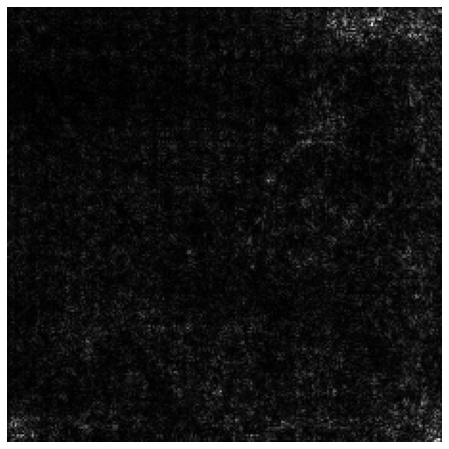

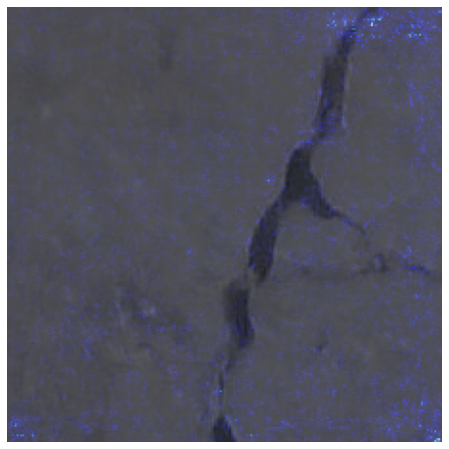

In [79]:
do_salience(img,model,1)

In [80]:
model.compile(loss = 'SparseCategoricalCrossentropy',metrics = ['accuracy'],optimizer= tf.keras.optimizers.RMSprop(lr=0.001))

In [85]:
trainX.clear()
trainY.clear()

In [82]:
ListX = np.array(trainX,dtype=np.float32)

In [92]:
len(trainY)
len(trainX)

8500

In [93]:
ListX=tf.convert_to_tensor(ListX)
ListY = tf.convert_to_tensor(trainY)

In [95]:
model.fit(ListX,ListY,batch_size=64,epochs=35)

Epoch 1/35
133/133 [==============================] - 16s 117ms/step - loss: 0.4118 - accuracy: 0.8287
Epoch 2/35
133/133 [==============================] - 16s 117ms/step - loss: 0.3443 - accuracy: 0.8573
Epoch 3/35
133/133 [==============================] - 16s 117ms/step - loss: 0.3009 - accuracy: 0.8816
Epoch 4/35
133/133 [==============================] - 15s 117ms/step - loss: 0.2509 - accuracy: 0.9076
Epoch 5/35
133/133 [==============================] - 16s 117ms/step - loss: 0.2391 - accuracy: 0.9122
Epoch 6/35
133/133 [==============================] - 15s 117ms/step - loss: 0.2189 - accuracy: 0.9220
Epoch 7/35
133/133 [==============================] - 16s 117ms/step - loss: 0.2079 - accuracy: 0.9236
Epoch 8/35
133/133 [==============================] - 16s 117ms/step - loss: 0.1883 - accuracy: 0.9326
Epoch 9/35
133/133 [==============================] - 16s 117ms/step - loss: 0.1808 - accuracy: 0.9335
Epoch 10/35
133/133 [==============================] - 16s 117ms/step - l

In [96]:
img ='/content/train/Positive/00002.jpg'  
img=  Convert_img(img)

In [ ]:
trainX.clear()
trainY.clear()

In [ ]:
def show_image(img):
  plt.figure(figsize=(8, 8))
  plt.axis('off')
  plt.imshow(img)
  plt.show()

### The Following image shows condition of model prediction when untrained

tf.Tensor([[0.27485165 0.7251484 ]], shape=(1, 2), dtype=float32)


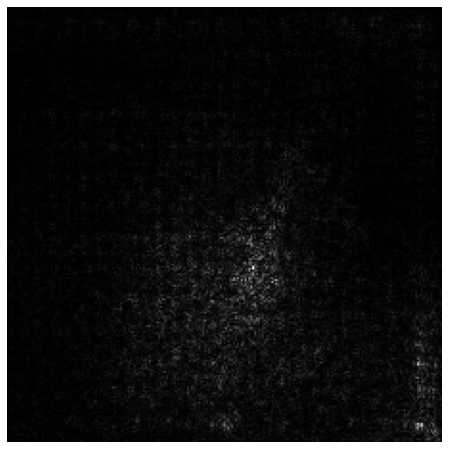

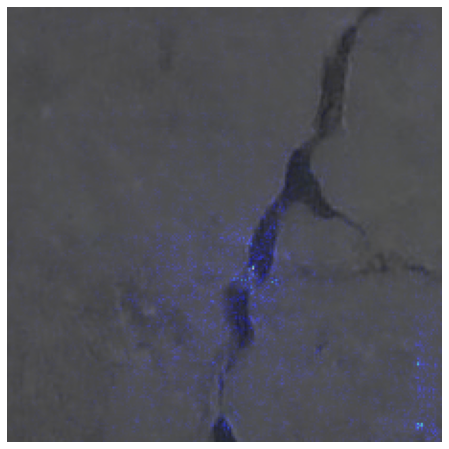

In [97]:
do_salience(img,model,1)
#show_image(img)

In [99]:
 p1 = '/content/val/Positive/00005.jpg'
 p2 = '/content/val/Positive/00007.jpg'
 p3 = '/content/val/Positive/00024.jpg'
 n4 = '/content/val/Negative/00004.jpg'
 n5 = '/content/val/Negative/00042.jpg'

In [100]:
p1 =   Convert_img(p1)
p2 =   Convert_img(p2)
p3 =   Convert_img(p3)
n4 =   Convert_img(n4)
n5 =   Convert_img(n5)

### Prediction when model is trained

tf.Tensor([[0.39904752 0.6009525 ]], shape=(1, 2), dtype=float32)


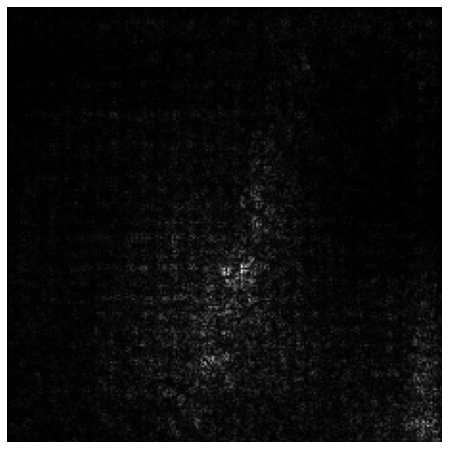

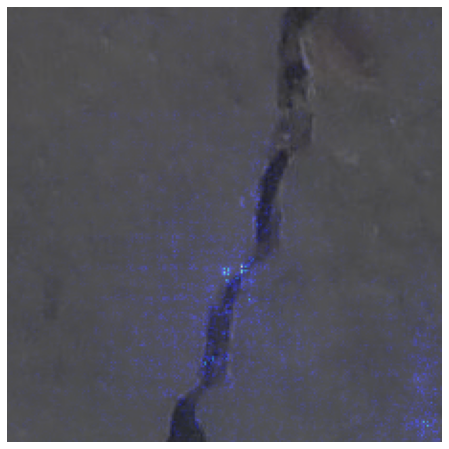

tf.Tensor([[5.9948413e-04 9.9940050e-01]], shape=(1, 2), dtype=float32)


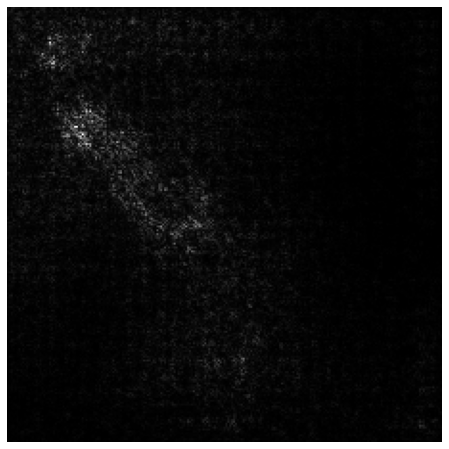

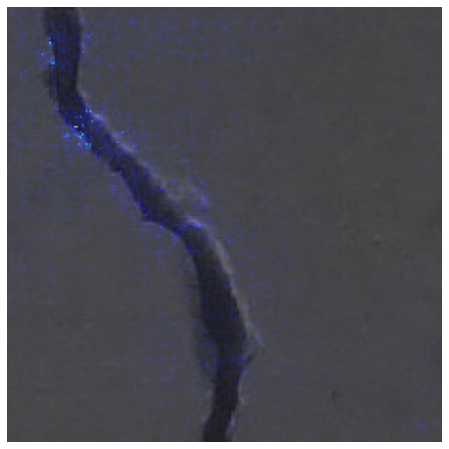

tf.Tensor([[0.0872911 0.9127089]], shape=(1, 2), dtype=float32)


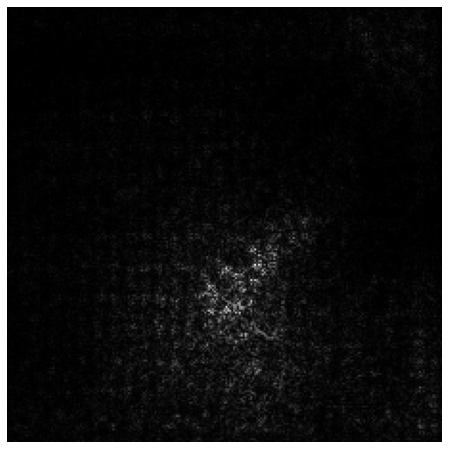

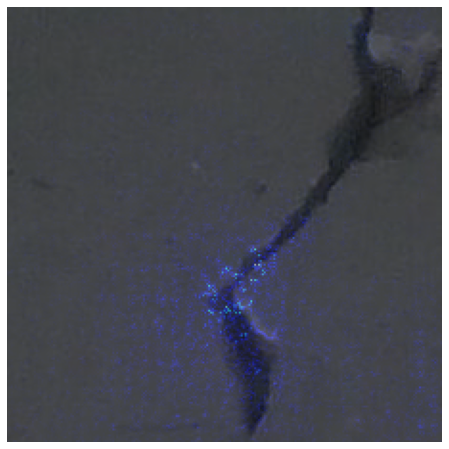

tf.Tensor([[0.989365   0.01063503]], shape=(1, 2), dtype=float32)


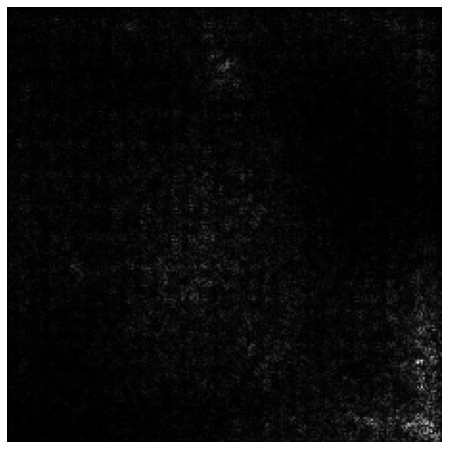

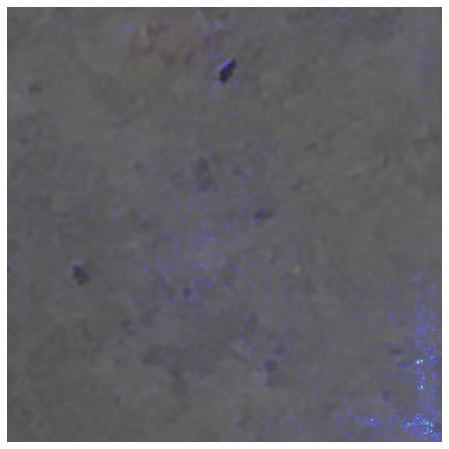

tf.Tensor([[0.93293893 0.06706102]], shape=(1, 2), dtype=float32)


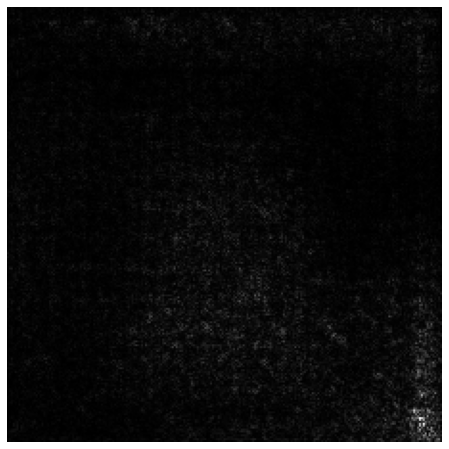

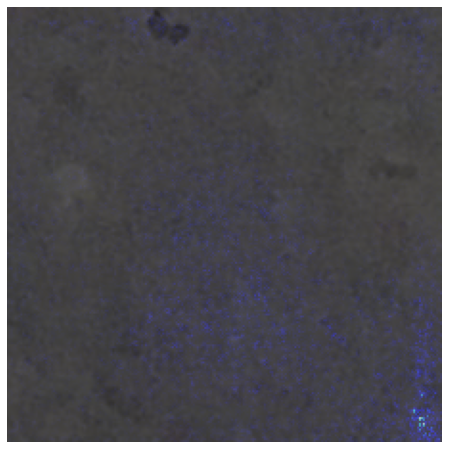

In [103]:
do_salience(p1,model,1)
do_salience(p2,model,1)
do_salience(p3,model,1)
do_salience(n4,model,0)
do_salience(n5,model,0)